In [1]:
'''
T1_BT19_Icub_joint_ae + store latent space vector in 
"df_latent_all_epochs.pkl"
'''
# Import

import os,sys
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../new_iteration/")
import pickle
import argparse
from sklearn.metrics import confusion_matrix
from datetime import datetime

from vrae.vrae import VRAEC
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as data2
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from tas_utils_bs import get_trainValLoader, get_testLoader
import plotly

import time
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.animation import ArtistAnimation
%matplotlib inline

In [2]:
# Set hyper params
num_class = 20
sequence_length_B = 400
sequence_length_I = 75
number_of_features_B = 19
number_of_features_I = 60

hidden_size = 90
hidden_layer_depth = 1
latent_length = 40
batch_size = 32
learning_rate = 0.0005
n_epochs = 5
dropout_rate = 0.2
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
header_B = None
header_I = "CNN"

w_r = 0.0001
w_k = 1
w_c = 1
np.random.seed(1)
torch.manual_seed(1)

### Load data and preprocess

In [3]:
# Load data
data_dir = '../../new_data_folder/'
kfold_number = 0

logDir = 'models_and_stat/'
model_name_B = "testB"#'BT19_joint_hs_{}_ll_{}_hl{}_lr_{}_wr_{}_wk_{}_wc_{}_{}'.format(hidden_size, latent_length, hidden_layer_depth, learning_rate, w_r,w_k, w_c, str(kfold_number))
model_name_I = "testI"#'IcubCNN_joint_hs_{}_ll_{}_hl{}_lr_{}_wr_{}_wk_{}_wc_{}_{}'.format(hidden_size, latent_length, hidden_layer_depth, learning_rate, w_r,w_k, w_c, str(kfold_number))
device = torch.device("cuda:2")

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=kfold_number, spike_ready=False, batch_size=batch_size)
test_loader, test_dataset = get_testLoader(data_dir, spike_ready=False, batch_size=batch_size)

In [4]:
model_B = VRAEC(num_class=num_class,
            sequence_length=sequence_length_B,
            number_of_features = number_of_features_B,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_B,
            header=header_B,
            device = device)
model_B.to(device)

model_I = VRAEC(num_class=num_class,
            sequence_length=sequence_length_I,
            number_of_features = number_of_features_I,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_I,
            header=header_I,
            device = device)
model_I.to(device)

/home/students/student6_16/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



VRAE(n_epochs=5,batch_size=32,cuda=True)

In [5]:
criterion = nn.CrossEntropyLoss()
optimB = optim.Adam(model_B.parameters(), lr=learning_rate)
optimI = optim.Adam(model_I.parameters(), lr=learning_rate)
cl_loss_fn = nn.NLLLoss()
recon_loss_fn = nn.MSELoss()

last batch training: LB: 0.59, LI: 0.29, LC: 6.83 
train_num 576, val_num 192
Epoch 0: Loss: lc 5.874,  train_B 0.020, val_B 0.023, train_I0.013, val_I0.020, 
		 Acc: train_B 0.861, val_B 0.781, train_I 0.901, val_I 0.818
--------------------
Saving model at 0 epoch to models_and_stat/testB.pt
Saving model at 0 epoch to models_and_stat/testI.pt
--------------------
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.000s...
[t-SNE] Computed neighbors for 192 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 5.784373
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.167370
[t-SNE] KL divergence after 300 iterations: 0.174832
last batch training: LB: 0.47, LI: 0.34, LC: 7.19 
train_num 576, val_num 192
Epoch 1: Loss: lc 6.965,  train_B 0.018, val_B 0.020, train_I0.012, val_I0.016, 
		 Acc: train_B 0.875, val_B 0.844, train_I 0.898, val_I 0.823
--------------------
Saving model at 1 epoch t

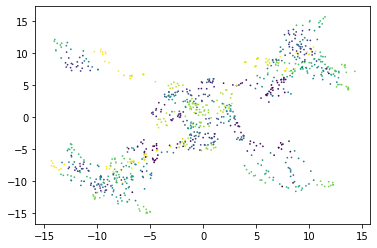

In [9]:
# Train
training_start=datetime.now()

epoch_train_loss_B = []
epoch_train_acc_B = []
epoch_val_loss_B = []
epoch_val_acc_B = []
max_val_acc_B = 0

epoch_train_loss_I = []
epoch_train_acc_I = []
epoch_val_loss_I = []
epoch_val_acc_I = []

epoch_train_tot_loss = []
epoch_val_tot_loss = []
max_val_acc_I = 0


# create an empty dataframe to store prediction of valid_dataset
latent_B_cols = ['latentB_'+str(i) for i in range(latent_length)]
latent_I_cols = ['latentI_'+str(i) for i in range(latent_length)]
tsne_columns = ['latentB_tsne-2d-one', 'latentB_tsne-2d-two']
df_latent_all_epochs = pd.DataFrame(columns=['epoch']+latent_I_cols+latent_B_cols+['y']+tsne_columns)
images = []

for epoch in range(n_epochs):

    # TRAIN
    model_B.train()
    model_I.train()

    correct_B = 0
    train_loss_B = 0
    correct_I = 0
    train_loss_I = 0
    train_loss_tot = 0
    train_num = 0

    for i, (XI, XB,  y) in enumerate(train_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        train_num += XI.size(0)
        
        # train model_B
        optimB.zero_grad()  
        x_decoded, latent_B, output = model_B(XB)
        # construct loss function
        cl_loss_B = cl_loss_fn(output, y)
        recon_loss_B = recon_loss_fn(x_decoded, XB)
        loss_B = w_r*recon_loss_B + w_c*cl_loss_B

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train_loss_B += loss_B.item()
        
        
        # train modelI
        optimI.zero_grad()  
        x_decoded, latent_I, output = model_I(XI)
        # construct loss function
        cl_loss_I = cl_loss_fn(output, y)
        recon_loss_I = recon_loss_fn(x_decoded, XI)
        loss_I = w_r*recon_loss_I + w_c*cl_loss_I

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train_loss_I += loss_I.item()
        
#         print("latent_B {}, latent_I {}".format(latent_B, latent_I))
        
#         loss_C = F.mse_loss(latent_B, latent_I)
        loss_C = F.mse_loss(latent_B,latent_I)
        loss = loss_B + loss_I + loss_C
        
        if epoch < 20:
            loss_B.backward()
            loss_I.backward()
        else:
            loss.backward()
        
        train_loss_tot += loss.item()
        
        optimB.step() 
        optimI.step() 
    
    if epoch < 20 or epoch%200 == 0:
        print("last batch training: LB: {:.2f}, LI: {:.2f}, LC: {:.2f} "\
              .format(loss_B, loss_I, loss_C))
    
    # fill stats
    train_accuracy_B = correct_B / train_num # len(train_loader.dataset)
    train_loss_B /= train_num #len(train_loader.dataset)
    epoch_train_loss_B.append(train_loss_B)
    epoch_train_acc_B.append(train_accuracy_B) 
    
    train_accuracy_I = correct_I / train_num # len(train_loader.dataset)
    train_loss_I /= train_num #len(train_loader.dataset)
    epoch_train_loss_I.append(train_loss_I)
    epoch_train_acc_I.append(train_accuracy_I) 
    

    # VALIDATION
    model_B.eval()
    model_I.eval()

    correct_B = 0
    val_loss_B = 0
    correct_I = 0
    val_loss_I = 0
    val_loss_tot = 0
    val_num = 0
    df_latent = pd.DataFrame(columns=['epoch']+latent_I_cols+latent_B_cols+['y'])


    for i, (XI, XB,  y) in enumerate(val_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        val_num += XI.size(0)
        
        # eval model_B
        x_decoded_B, latent_B, output_B = model_B(XB)
        
                
        # construct loss function
        cl_loss_B = cl_loss_fn(output_B, y)
        recon_loss_B = recon_loss_fn(x_decoded_B, XB)
        loss_B = w_r*recon_loss_B + w_c*cl_loss_B

        
        # compute classification acc
        pred_B = output_B.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred_B.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val_loss_B += loss_B.item()
        
        
        # eval modelI  
        x_decoded_I, latent_I, output_I = model_I(XI)
        # construct loss function
        cl_loss_I = cl_loss_fn(output_I, y)
        recon_loss_I = recon_loss_fn(x_decoded_I, XI)
        loss_I = w_r*recon_loss_I + w_c*cl_loss_I

        # compute classification acc
        pred_I = output_I.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred_I.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        loss = loss_B + loss_I + loss_C
        val_loss_tot += loss.item()
        
        
        # store dataframe for tsne plots
        latent_I = latent_I.data.cpu().numpy()
        latent_B = latent_B.data.cpu().numpy()
        y = y.data.cpu().numpy()
        epoch_column = np.repeat(epoch, batch_size)
        latent_array = np.concatenate((epoch_column[:, None], latent_I, latent_B, y[:, None]), axis=1)
        df_latent_temp = pd.DataFrame(latent_array, columns=['epoch']+latent_I_cols+latent_B_cols+['y'])

        df_latent = df_latent.append(df_latent_temp)
    

    # fill stats
    val_accuracy_B = correct_B / val_num # len(train_loader.dataset)
    val_loss_B /= val_num #len(train_loader.dataset)
    epoch_val_loss_B.append(val_loss_B)
    epoch_val_acc_B.append(val_accuracy_B) 
    
    val_accuracy_I = correct_I / val_num # len(train_loader.dataset)
    val_loss_I /= val_num #len(train_loader.dataset)
    epoch_val_loss_I.append(val_loss_I)
    epoch_val_acc_I.append(val_accuracy_I) 
    
    if epoch < 20 or epoch%200 == 0:
        print("train_num {}, val_num {}".format(train_num, val_num))
        print("Epoch {}: Loss: lc {:.3f},  train_B {:.3f}, val_B {:.3f}, train_I{:.3f}, val_I{:.3f}, \n\t\t Acc: train_B {:.3f}, val_B {:.3f}, train_I {:.3f}, val_I {:.3f}"\
              .format(epoch, loss_C, train_loss_B, val_loss_B, train_loss_I, val_loss_I, train_accuracy_B, val_accuracy_B, train_accuracy_I, val_accuracy_I))
        print("-"*20)
    
    # choose model
    # TODO: not save at the same time, may have bad common representation
    if max_val_acc_B <= val_accuracy_B:
        model_dir = logDir + model_name_B + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_B = val_accuracy_B
        torch.save(model_B.state_dict(), model_dir)

    if max_val_acc_I <= val_accuracy_I:
        model_dir = logDir + model_name_I + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_I = val_accuracy_I
        torch.save(model_I.state_dict(), model_dir)
    
    print("-"*20)
    
    # visualize training process
    data_subset_B = df_latent[latent_B_cols].values
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset_B)
    df_latent['latentB_tsne-2d-one'] = tsne_results[:,0]
    df_latent['latentB_tsne-2d-two'] = tsne_results[:,1]
    df_latent_all_epochs = df_latent_all_epochs.append(df_latent)
#     latent_B_tsne_plot = sns.scatterplot(
#         x="latentB_tsne-2d-one", y="latentB_tsne-2d-two",
#         hue="y",
#         palette=sns.color_palette("hls", 20, desat=1),
#         data=df_latent,
#         legend="full",
#         alpha=0.3
#     )
#     fig_B = latent_B_tsne_plot.get_figure()    
#     fig_B.savefig("latent_B_tsne_plot.png")
    img = plt.scatter(df_latent['latentB_tsne-2d-one'], df_latent['latentB_tsne-2d-two'], c=df_latent['y'],
                  marker='o', s=3, edgecolor='')
    images.append([img])

# fig = plt.figure(figsize=(16,10))
# ani = ArtistAnimation(fig, images, interval=100, repeat_delay=2000)
# ani.save("mlp_process.mp4")
pickle.dump(images, open("figures/plot_images.pkl", "wb"))
df_latent_all_epochs.to_pickle("df_latent_all_epochs.pkl") 
    
training_end =  datetime.now()
training_time = training_end -training_start 
print("training takes time {}".format(training_time)) 

In [ ]:
model_B.is_fitted = True
model_I.is_fitted = True

In [ ]:
model_B_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_B,
            number_of_features = number_of_features_B,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_B,
            header=header_B,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)
model_B_trained.load_state_dict(torch.load(logDir + model_name_B + '.pt'))
model_B_trained.to(device)
model_B_trained.eval()

model_I_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_I,
            number_of_features = number_of_features_I,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_I,
            header=header_I,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)
model_I_trained.load_state_dict(torch.load(logDir + model_name_I + '.pt'))
model_I_trained.to(device)
model_I_trained.eval()

In [ ]:
# TEST
model_B_trained.eval()
model_I_trained.eval()

correct_B = 0
correct_I = 0
test_num = 0

for i, (XI, XB,  y) in enumerate(test_loader):
    XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)

    if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break

    test_num += XI.size(0)

    # test model_B
    x_decoded, latent, output = model_B_trained(XB)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()



    # test modelI 
    x_decoded, latent, output = model_I_trained(XI)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

test_acc_B = correct_B/test_num
test_acc_I = correct_I/test_num
print('Test accuracy for {} fold {} samples: B {}, I {}'.format(str(kfold_number),test_num, test_acc_B, test_acc_I))

In [ ]:
# plot_clustering(z_runs[0], y_val[0], engine='matplotlib', download = True, folder_name='figures', filefix='_BT19_joint_{}'.format(n_epochs))



In [ ]:
# plot_clustering(z_runs[1], y_val[1], engine='matplotlib', download = True, folder_name='figures', filefix='_Icub_joint_{}'.format(n_epochs))

In [ ]:
# save stats
results_dict = {"epoch_train_loss_B": epoch_train_loss_B,
                "epoch_train_loss_I": epoch_train_loss_I,
                "epoch_val_loss_B": epoch_val_loss_B,
                "epoch_val_loss_I": epoch_val_loss_I,
                "epoch_train_acc_B": epoch_train_acc_B,
                "epoch_train_acc_I": epoch_train_acc_I,
                "epoch_val_acc_B": epoch_val_acc_B,
                "epoch_val_acc_I": epoch_val_acc_I,
                "test_acc": [test_acc_B, test_acc_I]}
dict_name = "T1_BI_joint.pkl"
pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
print("dump results dict to {}".format(dict_name))



### plot the train acc

In [ ]:
assert n_epochs == len(epoch_train_acc_B), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc_B, label="train acc B")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
assert n_epochs == len(epoch_train_acc_I), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc_I, label="train acc I")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
plt.show()
